# Introduction
We are trying domain shift analysis on the two datasets below:
* Wisconsin Breast Cancer Database (BCD) (https://www.kaggle.com/datasets/roustekbio/breast-cancer-csv) [2,3].
* Breast Cancer Wisconsin (Diagnostic) Data Set (WDBCD) (https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) [4].


In [5]:
#!pip install tensorflow

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

#import os
#print(os.listdir("../input"))
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

%matplotlib inline 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils



#Import models from scikit learn module:
from sklearn import datasets,metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

#Measuring Time
import time


In [7]:
print(tf.__version__)

2.18.0


# Parameters

In [8]:
epoch=50            # Epoch for machine learning training
train_split=0.4    #40% splitting
comps=9             # PCA Components

# Loading Dataset

## Load WDBC

In [9]:
#load dataset
data_train = pd.read_csv("/kaggle/input/breast-cancer-wisconsin-data/data.csv",header = 0)
data_train.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Load BCD

In [10]:
#load dataset
data_test = pd.read_csv("/kaggle/input/breast-cancer-csv/breastCancer.csv",header = 0)
print(type(data_test))
data_test.head(5)

<class 'pandas.core.frame.DataFrame'>


,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


# Data Preprocessing

## Prepare and clean the dataset
### Features

In [11]:
print("Train Data")
print("="*20)
print(data_train.info())

print("\n\nTest Data")
print("="*20)
print(data_test.info())

Train Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se   

## Remove unwanted info

In [12]:
# Drop features that are not usable
data_train.drop(['id','Unnamed: 32'],axis=1,inplace=True)
data_test.drop(['id'],axis=1,inplace=True)

## Check for NaN values
unique = 1 means here are no NaN values

In [13]:
data_test = data_test[data_test['bare_nucleoli'] != "?"]
data_test['bare_nucleoli'] = data_test['bare_nucleoli'].astype(int)

In [14]:
print("Train Data")
print("="*20)
print(data_train.isnull().any().describe())
print("\nTest Data")
print("="*20)
print(data_test.isnull().any().describe())

Train Data
count        31
unique        1
top       False
freq         31
dtype: object

Test Data
count        10
unique        1
top       False
freq         10
dtype: object




### Note:
We notice **bare_nucleoli** has _object_ datatype, so we have to correct it.

Let's remove the values.

## Get Classes
Let's use small y for unprocessed input

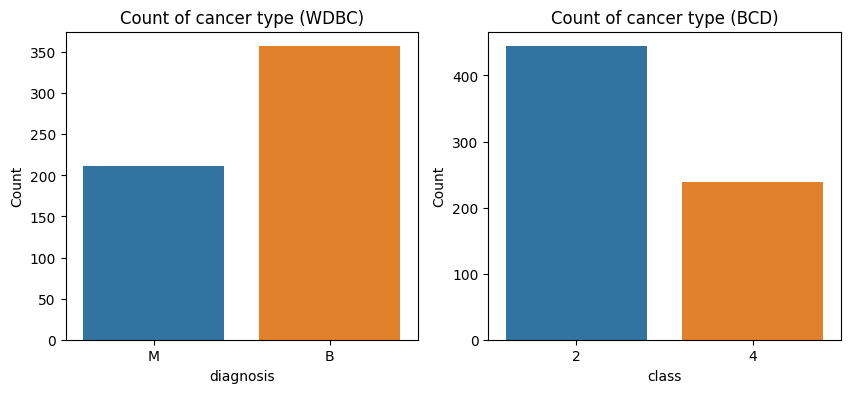

In [15]:
# Get the classes
y_train=data_train["diagnosis"]
y_test = data_test["class"]


#Plot the graph values
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax1.set_title('Count of cancer type (WDBC)')
sns.countplot(x="diagnosis",data=data_train, ax=ax1)
ax1.set_ylabel('Count')

ax2.set_title('Count of cancer type (BCD)')
sns.countplot(x="class",data=data_test, ax=ax2)
ax2.set_ylabel('Count')
plt.show()



# and remove them from the main datasets
data_train.drop(['diagnosis'],axis=1,inplace=True)
data_test.drop(['class'],axis=1,inplace=True)

## Observations*
1. Mean values of cell like radius, perimeter, area, compactness, concavity,concave points etc can be used in classification of the cancer. Larger values of these parameters tends to show a correlation with malignant tumors.
2. Mean values of column like texture, smoothness, symmetry or fractual dimension does not show a particular preference of one diagnosis over the other. In any of the histograms there are no noticeable large outliers that warrants further cleanup.

## Normalize data

In [16]:
scaler_data = StandardScaler()
data_train_scaled = scaler_data.fit_transform(data_train)

scaler_data_test = StandardScaler()
data_test_scaled = scaler_data_test.fit_transform(data_test) # Use the same scaler as WDBC

## Get the input (X)
We'll take the mean values only

In [17]:
cols = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 
        'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean']

features_WDBC = data_train.copy()
features_BCD = data_test.copy()

## PCA
### Checking PCA Components
Let's check the PCA components of the training and test set

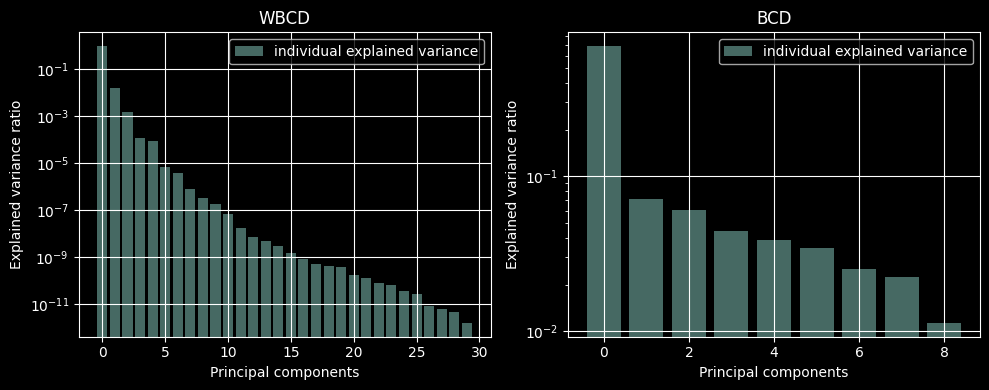

In [18]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(features_WDBC)
explained_variance=pca.explained_variance_ratio_


pca_test = PCA()
pca_test.fit_transform(features_BCD)
explained_variance_test=pca_test.explained_variance_ratio_



# We used a logarithmic scale in the y-axis because the first value is so high
with plt.style.context('dark_background'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    

    ax1.bar(range(len(features_WDBC.columns)), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    ax1.set_yscale('log')

    ax1.set_title("WBCD")
    ax1.set_ylabel('Explained variance ratio')
    ax1.set_xlabel('Principal components')
    ax1.legend(loc='best')
    ax1.grid(visible=True)


    ax2.set_title("BCD")
    ax2.bar(range(len(features_BCD.columns)), explained_variance_test, alpha=0.5, align='center',
            label='individual explained variance')
    ax2.set_yscale('log')
    
    ax2.set_ylabel('Explained variance ratio')
    ax2.set_xlabel('Principal components')
    ax2.legend(loc='best')
    ax2.grid(visible=True)


    
    # Adjust layout to prevent titles/labels from overlapping
    plt.tight_layout()

    #Display plot
    plt.show()

### Reducing Dimensions

In [19]:
#Training dataset
print(f"Reduce to {comps} components")
pca=PCA(n_components=comps)
X_train=pca.fit_transform(features_WDBC)


pca_test=PCA(n_components=comps)
X_test=pca_test.fit_transform(features_BCD)

Reduce to 9 components


## Convert Classes to one-hot

In [20]:
#Convert to Categorical values
Y_train = y_train.map({'B':0,'M':1})
Y_train = utils.to_categorical(Y_train, num_classes=2)


Y_test = y_test.map({2:0,4:1})
Y_test = utils.to_categorical(Y_test, num_classes=2)

## Reshaping

In [21]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((569, 9), (683, 9), (569, 2), (683, 2))

In [22]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [23]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((569, 9, 1), (683, 9, 1), (569, 2), (683, 2))

# Create teacher and student model

In [24]:
# Create the teacher
teacher =keras.Sequential()
teacher.add(keras.Input(shape=(X_train.shape[1],1)))
teacher.add(keras.layers.Conv1D(filters=64,kernel_size= 2,activation='relu'))
teacher.add(keras.layers.BatchNormalization())
teacher.add(keras.layers.Dropout(0.2))
        
teacher.add(keras.layers.Conv1D(448, 2,activation='relu'))
teacher.add(keras.layers.BatchNormalization())
teacher.add(keras.layers.Dropout(0.2))
        
teacher.add(keras.layers.Flatten())
teacher.add(keras.layers.Dense(64,activation='relu'))
teacher.add(keras.layers.Dropout(0.2))

teacher.add(keras.layers.Dense(2,activation='sigmoid'))

teacher.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',
              metrics=['accuracy'])


# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=(X_train.shape[1], 1)),
        layers.Conv1D(4, 2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
       # layers.LeakyReLU(alpha=0.2),
        
        layers.Conv1D(8, 2),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(2,activation='sigmoid'),
    ],
    name="student",)
    

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

#compile STUDENT
student_scratch.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',
              metrics=['accuracy'])

print( sep='\n')
print('STUDENT')

2025-11-28 18:35:33.672160: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



STUDENT


In [25]:
teacher.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 7, 448)         │        57,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 448)         │         1,792 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 448)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,930 (1019.26 KB)

 Trainable params: 259,906 (1015.26 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [26]:
student.summary()

Model: "student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 8, 4)           │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 7, 8)           │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 8)           │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           114 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246 (984.00 B)

 Trainable params: 222 (888.00 B)

 Non-trainable params: 24 (96.00 B)

## Splitting WDBC

In [27]:
X_WDBC_train,X_WDBC_test,Y_WDBC_train,Y_WDBC_test= train_test_split(X_train,Y_train,test_size=train_split,stratify=Y_train) #test_size=0.15

## Teacher Model training

In [28]:
start_time = time.time()
teacher_history=teacher.fit(X_WDBC_train,Y_WDBC_train,epochs=epoch,validation_data=(X_WDBC_test,Y_WDBC_test),verbose=1)
end_time = time.time()
print( sep='\n')

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7142 - loss: 0.6331 - val_accuracy: 0.9167 - val_loss: 0.2856
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8940 - loss: 0.2729 - val_accuracy: 0.9254 - val_loss: 0.2655
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9197 - loss: 0.2332 - val_accuracy: 0.9298 - val_loss: 0.2551
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9364 - loss: 0.1620 - val_accuracy: 0.9254 - val_loss: 0.2439
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9352 - loss: 0.1690 - val_accuracy: 0.9298 - val_loss: 0.2377
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9365 - loss: 0.1989 - val_accuracy: 0.9298 - val_loss: 0.2373
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9246 - loss: 0.1604 - val_accuracy: 0.9298 - val_loss: 0.2304
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9709 - loss: 0.1134 - val_accuracy: 0.9342 - v

## Teacher Evaluation

In [29]:
teacher_loss, teacher_acc = teacher.evaluate(X_test, Y_test)
print(f"accuracy: {teacher_acc} loss: {teacher_loss}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6378 - loss: 0.6912
accuracy: 0.6896046996116638 loss: 0.6185383796691895


## Student Model without KD Training

In [30]:
start_time = time.time()
student_scratch_history=student_scratch.fit(X_WDBC_train,Y_WDBC_train,epochs=epoch,validation_data=(X_WDBC_test,Y_WDBC_test),verbose=1)
end_time = time.time()
print( sep='\n')

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4391 - loss: 0.9000 - val_accuracy: 0.7018 - val_loss: 0.8737
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4388 - loss: 0.9044 - val_accuracy: 0.8596 - val_loss: 0.7881
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4439 - loss: 0.8699 - val_accuracy: 0.8947 - val_loss: 0.7550
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5397 - loss: 0.8723 - val_accuracy: 0.9035 - val_loss: 0.7350
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5075 - loss: 0.8779 - val_accuracy: 0.9035 - val_loss: 0.7205
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5684 - loss: 0.7999 - val_accuracy: 0.9123 - val_loss: 0.7087
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5578 - loss: 0.8261 - val_accuracy: 0.9123 - val_loss: 0.6987
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5602 - loss: 0.8289 - val_accuracy: 0.9079 - v

## Evaluate Student Scratch

In [31]:
student_scratch_loss, student_scratch_acc = student_scratch.evaluate(X_test, Y_test)

print(f"accuracy: {student_scratch_acc} loss: {student_scratch_loss}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5893 - loss: 0.6770 
accuracy: 0.650073230266571 loss: 0.6701071858406067


# Knowledge Distillation
## Construct distiller class

In [32]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [33]:
 # Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(optimizer=keras.optimizers.Adam(),
metrics=['accuracy'],
student_loss_fn= keras.losses.BinaryCrossentropy() ,
distillation_loss_fn=keras.losses.KLDivergence(),
alpha=0.1,
temperature=10,
)

## Distill Teacher to Student

In [34]:
print( sep='\n')
print('DISTILL TEACHER TO STUDENT')
start_time = time.time()
kd_history=distiller.fit(X_WDBC_train, Y_WDBC_train, epochs=epoch, verbose=1, validation_data=(X_WDBC_test,Y_WDBC_test))
end_time = time.time()
print( sep='\n')


DISTILL TEACHER TO STUDENT
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4348 - distillation_loss: 0.0013 - loss: 0.4790 - student_loss: 0.8901 - val_loss: 0.4730 - val_student_loss: 0.4602
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6083 - distillation_loss: 0.0011 - loss: 0.4715 - student_loss: 0.7617 - val_loss: 0.4863 - val_student_loss: 0.4519
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7090 - distillation_loss: 9.4085e-04 - loss: 0.4866 - student_loss: 0.6806 - val_loss: 0.4924 - val_student_loss: 0.4634
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8508 - distillation_loss: 7.7955e-04 - loss: 0.4904 - student_loss: 0.5938 - val_loss: 0.4952 - val_student_loss: 0.4771
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8558 - distillation_loss: 6.8277e-04 - loss: 0.4975 - student_loss: 0.5293 - val_loss: 0.4975 - val_student_loss: 0.4900
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8764 - distillation_loss

In [35]:
print("KD History List:", kd_history.history.keys())

KD History List: dict_keys(['accuracy', 'distillation_loss', 'loss', 'student_loss', 'val_loss', 'val_student_loss'])


### Validation
We cannot get validation from the new version of TensorFlow. So we use the evaluation function:

In [36]:
distiller_evaluate_output = distiller.evaluate(X_WDBC_test,Y_WDBC_test)

#Sample output:
#[<tf.Tensor: shape=(), dtype=float32, numpy=0.49883049726486206>,
# {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.9069767594337463>},
# <tf.Tensor: shape=(), dtype=float32, numpy=0.15347284078598022>]

# The first element in the list is the student's loss.
# We use .numpy() to get the numerical value.
distiller_val_total_loss = distiller_evaluate_output[0].numpy()

# The second element is a dictionary. We access the 'accuracy' key
# and then get its numpy value.
distiller_val_accuracy = distiller_evaluate_output[1]['accuracy'].numpy()

# The third element is the total combined loss.
distiller_val_student_loss = distiller_evaluate_output[2].numpy()

print(f"accuracy: {distiller_val_accuracy} loss: {distiller_val_total_loss} student_loss: {distiller_val_student_loss}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9320 - loss: 0.4987 - student_loss: 0.2498 
accuracy: 0.9254385828971863 loss: 0.49872833490371704 student_loss: 0.4371505379676819


## Evaluate Distilled Student

In [37]:
distiller_evaluate_output = distiller.evaluate(X_test, Y_test)

#Sample output:
#[<tf.Tensor: shape=(), dtype=float32, numpy=0.49883049726486206>,
# {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.9069767594337463>},
# <tf.Tensor: shape=(), dtype=float32, numpy=0.15347284078598022>]

# The first element in the list is the student loss.
# We use .numpy() to get the numerical value.
distiller_total_loss = distiller_evaluate_output[0].numpy()

# The second element is a dictionary. We access the 'accuracy' key
# and then get its numpy value.
distiller_accuracy = distiller_evaluate_output[1]['accuracy'].numpy()

# The third element is the total combined loss.
distiller_student_loss = distiller_evaluate_output[2].numpy()

print(f"accuracy: {distiller_accuracy} loss: {distiller_total_loss} student_loss: {distiller_student_loss}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7157 - loss: 0.5067 - student_loss: 0.6558 
accuracy: 0.7569546103477478 loss: 0.5073346495628357 student_loss: 0.662019670009613


# Result Summary

In [38]:
print("Values \t\t\t TM \t\t SM_scratch \t SM")
print("="*65)
print("Acc. (%%) \t\t %.2f \t\t %.2f \t\t %.2f"%(teacher_history.history['accuracy'][epoch-1]*100,student_scratch_history.history['accuracy'][epoch-1]*100,kd_history.history['accuracy'][epoch-1]*100))
print("Val. Acc. (%%) \t\t %.2f \t\t %.2f \t\t %.2f"%(teacher_history.history['val_accuracy'][epoch-1]*100,student_scratch_history.history['val_accuracy'][epoch-1]*100,distiller_val_accuracy*100))
print("Eval. Acc. (%%) \t\t %.2f \t\t %.2f \t\t %.2f"%(teacher_acc*100,student_scratch_acc*100,distiller_accuracy*100))
print("Loss. (%%) \t\t %.2f \t\t %.2f \t\t %.2f"%(teacher_history.history['loss'][epoch-1]*100,student_scratch_history.history['loss'][epoch-1]*100,kd_history.history['loss'][epoch-1]*100))
print("Val. Loss. (%%) \t\t %.2f \t\t %.2f \t\t %.2f"%(teacher_history.history['val_loss'][epoch-1]*100,student_scratch_history.history['val_loss'][epoch-1]*100,kd_history.history['val_loss'][epoch-1]*100))
print("Eval. Loss. (%%) \t %.2f \t\t %.2f \t\t %.2f"%(teacher_loss*100,student_scratch_loss*100,distiller_student_loss*100))
print("="*65)


Values 			 TM 		 SM_scratch 	 SM
Acc. (%) 		 97.07 		 84.46 		 92.54
Val. Acc. (%) 		 95.61 		 89.04 		 92.54
Eval. Acc. (%) 		 68.96 		 65.01 		 75.70
Loss. (%) 		 7.63 		 46.16 		 50.14
Val. Loss. (%) 		 12.05 		 42.46 		 49.87
Eval. Loss. (%) 	 61.85 		 67.01 		 66.20


In [39]:
print("PCA \t TM Acc \t SM_scr Acc \t SM Acc \t TM VAcc \t SM_scr VAcc \t SM VAcc \tTM EVAcc \t SM_scr EVAcc \t SM EVAcc")
print("%d \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f"
      %(comps,teacher_history.history['accuracy'][-1]*100,student_scratch_history.history['accuracy'][-1]*100,kd_history.history['accuracy'][-1]*100,
       teacher_history.history['val_accuracy'][-1]*100,student_scratch_history.history['val_accuracy'][-1]*100,distiller_val_accuracy*100,
       teacher_acc*100,student_scratch_acc*100,distiller_accuracy*100))

PCA 	 TM Acc 	 SM_scr Acc 	 SM Acc 	 TM VAcc 	 SM_scr VAcc 	 SM VAcc 	TM EVAcc 	 SM_scr EVAcc 	 SM EVAcc
9 	 97.0675 	 84.4575 	 92.5439 	 95.6140 	 89.0351 	 92.5439 	 68.9605 	 65.0073 	 75.6955


In [40]:
print("PCA \t TM Loss \t SM_scr Loss \t SM Loss \t TM VLoss \t SM_scr VLoss \t SM VLoss \tTM EVLoss \t SM_scr EVLoss \t SM EVLoss")
print("%d \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f"
      %(comps,teacher_history.history['loss'][-1],student_scratch_history.history['loss'][-1],kd_history.history['student_loss'][-1],
       teacher_history.history['val_loss'][-1],student_scratch_history.history['val_loss'][-1],kd_history.history['val_student_loss'][-1],
       teacher_loss,student_scratch_loss,distiller_student_loss))

PCA 	 TM Loss 	 SM_scr Loss 	 SM Loss 	 TM VLoss 	 SM_scr VLoss 	 SM VLoss 	TM EVLoss 	 SM_scr EVLoss 	 SM EVLoss
9 	 0.0763 	 0.4616 	 0.2331 	 0.1205 	 0.4246 	 0.4372 	 0.6185 	 0.6701 	 0.6620


In [41]:
res = open("result.txt", "a")

res.write("%d \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f"
      %(comps,teacher_history.history['accuracy'][-1]*100,student_scratch_history.history['accuracy'][-1]*100,kd_history.history['accuracy'][-1]*100,
       teacher_history.history['val_accuracy'][-1]*100,student_scratch_history.history['val_accuracy'][-1]*100,distiller_val_accuracy*100,
       teacher_acc*100,student_scratch_acc*100,distiller_accuracy*100))

res.write("\t\t%d \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f \t %.4f\n"
      %(comps,teacher_history.history['loss'][-1],student_scratch_history.history['loss'][-1],kd_history.history['student_loss'][-1],
       teacher_history.history['val_loss'][-1],student_scratch_history.history['val_loss'][-1],kd_history.history['val_student_loss'][-1],
       teacher_loss,student_scratch_loss,distiller_student_loss))

res.close()